In [1]:
# Core jax
import jax.numpy as np
import jax.random as jr
from jax import vmap

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.layers as dll
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.rcParams["image.origin"] = 'lower'

In [12]:
# Define arrays sizes, samplings, symmetries
wf_npix = 256
oversample = 3
nslice = 1

# Define basis hyper parameters
a = 10
b = 8
ith = 10

# Define coordinate grids
npix = wf_npix * oversample
c = (npix - 1) / 2.
xs = (np.arange(npix) - c) / c
XX, YY = np.meshgrid(xs, xs)
RR = np.sqrt(XX ** 2 + YY ** 2)
PHI = np.arctan2(YY, XX)

# Generate basis vectors to map over
As = np.arange(-a, a+1)
Bs = nslice * np.arange(0, b+1)
Cs = np.array([-np.pi/2, np.pi/2])
Is = np.arange(-ith, ith+1)

# Define basis functions
LRHF_fn = lambda A, B, C, RR, PHI: np.cos(A*np.log(RR + 1e-12) + B*PHI + C)
sine_fn = lambda i, RR: np.sin(i * np.pi * RR)
cose_fn = lambda i, RR: np.cos(i * np.pi * RR)

# Map over basis functions
gen_LRHF_basis = vmap(vmap(vmap( \
                            LRHF_fn, (None, 0, None, None, None)), 
                                     (0, None, None, None, None)), 
                                     (None, None, 0, None, None))
gen_sine_basis = vmap(sine_fn, in_axes=(0, None))
gen_cose_basis = vmap(cose_fn, in_axes=(0, None))

# Generate basis
LRHF_basis = gen_LRHF_basis(As, Bs, Cs, RR, PHI) \
            .reshape([len(As)*len(Bs)*len(Cs), npix, npix])
sine_basis = gen_sine_basis(Is, RR)
cose_basis = gen_cose_basis(Is, RR)

# Format shapes and combine
LRHF_flat = LRHF_basis.reshape([len(As)*len(Bs)*len(Cs), npix*npix])
sine_flat = sine_basis.reshape([len(sine_basis), npix*npix])
cose_flat = cose_basis.reshape([len(cose_basis), npix*npix])
full_basis = np.concatenate([
    LRHF_flat,
    sine_flat,
    cose_flat
])

In [13]:

from sklearn.decomposition import PCA
pca = PCA().fit(full_basis)

components = pca.components_.reshape([len(full_basis), npix, npix])
components = np.copy(components[:99,:,:])
basis = np.concatenate([np.mean(pca.mean_)*np.array(np.ones((1,npix,npix))), components])

# save for use later
np.save('bases/basis1', basis)

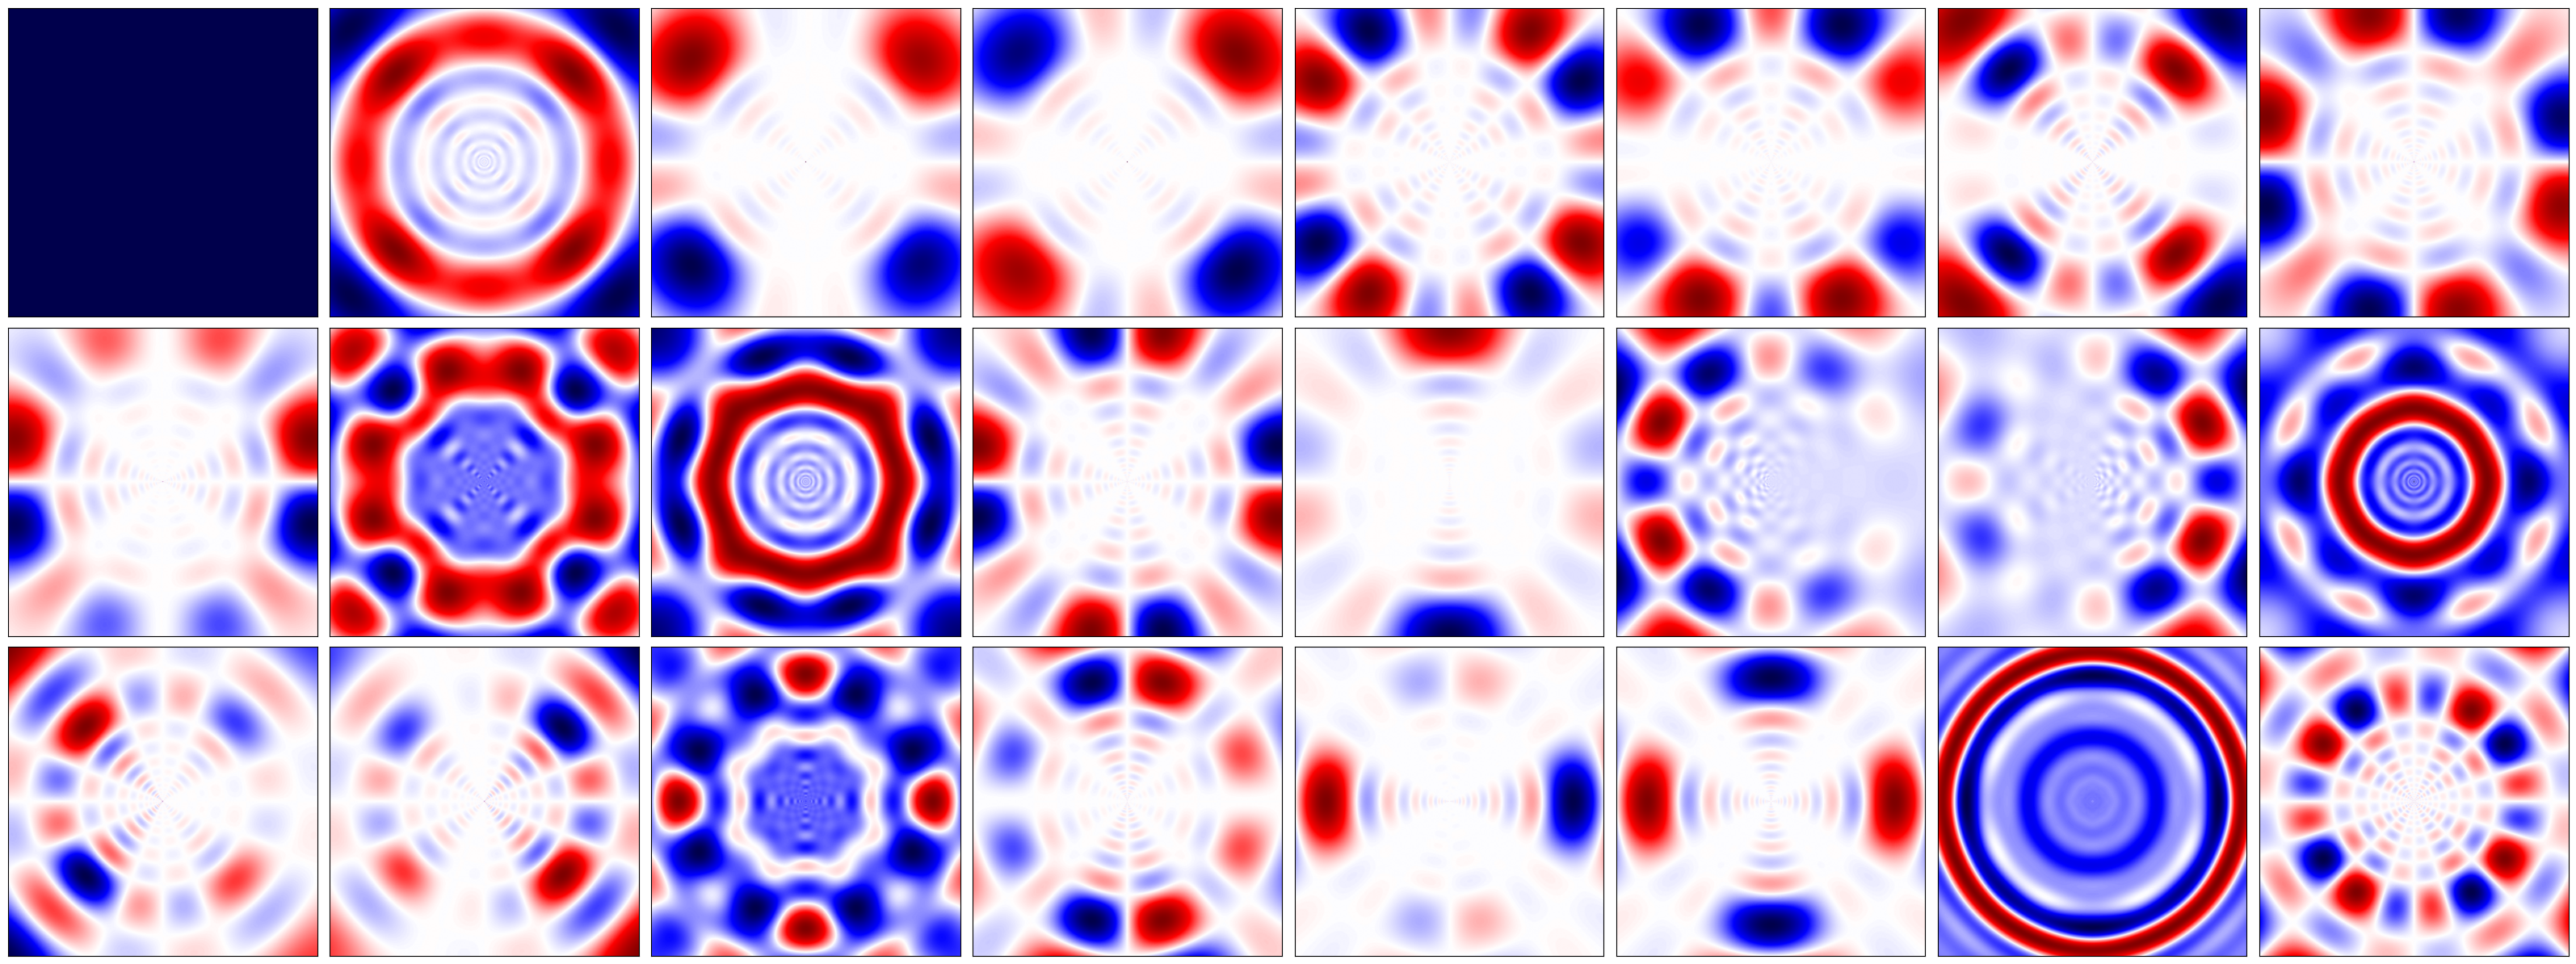

In [14]:
nfigs = 24
ncols = 8
nrows = 1 + nfigs//ncols

plt.figure(figsize=(4*ncols, 4*nrows))
for i in range(nfigs):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(basis[i], cmap='seismic')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [15]:
from dLuxToliman import TolimanOpticalSystem, ApplyBasisCLIMB

# Define our mask layer, here we use ApplyBasisCLIMB
wavels = 1e-9 * np.linspace(595, 695, 3)
coeffs = 100*jr.normal(jr.PRNGKey(0), [len(basis)])
CLIMB = ApplyBasisCLIMB(basis, np.mean(wavels), coeffs)
optics = TolimanOpticalSystem(psf_npixels=64, mask=CLIMB)

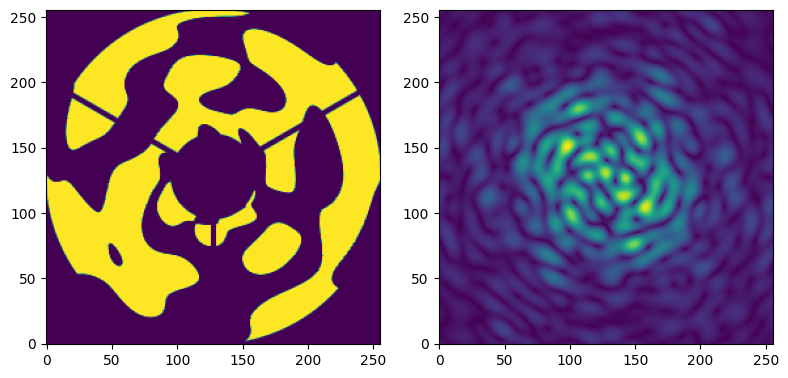

In [16]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(optics.pupil.get_binary_phase()*optics.aperture.transmission)

plt.subplot(1,2,2)
plt.imshow(optics.propagate(np.array([585e-9]))**0.5)

plt.tight_layout()
plt.show()